In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedGroupKFold, GroupKFold

from pathlib import Path

import pydicom

In [2]:
def split_fold(df_):
    df = df_.clone()
    
    fold_num = 4
    seed = 42
    
    sgkf = StratifiedGroupKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    splitter = np.zeros(df.height)
    
    for fold, (_, valid_idx) in enumerate(sgkf.split(X=df['study_id_level'], y=df['labels'], groups=df['study_id'])):
        splitter[valid_idx] = fold
    
    df = df.with_columns(fold=pl.Series(splitter).cast(pl.Int8))
    
    return df

In [3]:
train_solution = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
solution = (
    train_solution
    .melt(id_vars='study_id', variable_name='full_label', value_name='severity')
    .with_columns(pl.concat_str([
        pl.col('study_id'),
        pl.col('full_label')
    ], separator='_').alias('row_id'))
    .fill_null('Normal/Mild') # treat null as normal/mild
    .with_columns(pl.when(pl.col('severity') == 'Normal/Mild').then(1.).otherwise(0.).alias('normal_mild'))
    .with_columns(pl.when(pl.col('severity') == 'Moderate').then(1.).otherwise(0.).alias('moderate'))
    .with_columns(pl.when(pl.col('severity') == 'Severe').then(1.).otherwise(0.).alias('severe'))
    .with_columns(
        pl.when(pl.col('severity') == 'Normal/Mild')
        .then(1.)
        .when(pl.col('severity') == 'Moderate')
        .then(2.)
        .when(pl.col('severity') == 'Severe')
        .then(4.)
        .alias('sample_weight')
    )
    .select(["study_id", "row_id", "normal_mild", "moderate", "severe", "sample_weight"]).sort('row_id')
    .drop('study_id')
)
solution.write_csv('solution_df.csv')
solution

row_id,normal_mild,moderate,severe,sample_weight
str,f64,f64,f64,f64
"""100206310_left_neural_foramina…",1.0,0.0,0.0,1.0
"""100206310_left_neural_foramina…",0.0,1.0,0.0,2.0
"""100206310_left_neural_foramina…",0.0,1.0,0.0,2.0
"""100206310_left_neural_foramina…",0.0,0.0,1.0,4.0
"""100206310_left_neural_foramina…",0.0,1.0,0.0,2.0
…,…,…,…,…
"""998688940_spinal_canal_stenosi…",1.0,0.0,0.0,1.0
"""998688940_spinal_canal_stenosi…",1.0,0.0,0.0,1.0
"""998688940_spinal_canal_stenosi…",1.0,0.0,0.0,1.0


# Load Data

In [4]:
train = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_cor = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

train_images_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

In [5]:
axial_series = train_des.filter(pl.col('series_description') == 'Axial T2')
sagittal_series = train_des.filter(pl.col('series_description') != 'Axial T2')

In [6]:
original_train = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_null = original_train.melt(id_vars='study_id').filter(pl.col('value').is_null())['study_id'].unique(maintain_order=True).to_list()

In [7]:
cap2lower = {
    'Normal/Mild': 'normal_mild',
    'Moderate': 'moderate',
    'Severe': 'severe',
}

levels = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

condition_plane = {
    'sagittal' : [
        'left_neural_foraminal_narrowing',
        'right_neural_foraminal_narrowing',
        'spinal_canal_stenosis',
        'unknown',
    ],
    'axial': [
        'left_subarticular_stenosis',
        'right_subarticular_stenosis',
        'unknown',
    ]
}

# Create Study level labels

In [8]:
label_order = [
    'study_id_level',

    # sagittal_t1
    'left_neural_foraminal_narrowing_normal_mild',
    'left_neural_foraminal_narrowing_moderate',
    'left_neural_foraminal_narrowing_severe',

    'right_neural_foraminal_narrowing_normal_mild',
    'right_neural_foraminal_narrowing_moderate',
    'right_neural_foraminal_narrowing_severe',

    # sagittal_t2
    'spinal_canal_stenosis_normal_mild',
    'spinal_canal_stenosis_moderate',
    'spinal_canal_stenosis_severe',

    # axial
    'left_subarticular_stenosis_normal_mild',
    'left_subarticular_stenosis_moderate',
    'left_subarticular_stenosis_severe',

    'right_subarticular_stenosis_normal_mild',
    'right_subarticular_stenosis_moderate',
    'right_subarticular_stenosis_severe',
    
#     # unknown
#     'left_neural_foraminal_narrowing_unknown',
#     'right_neural_foraminal_narrowing_unknown',
#     'spinal_canal_stenosis_unknown',
#     'left_subarticular_stenosis_unknown',
#     'right_subarticular_stenosis_unknown',
]
label_order_dict = dict(zip(label_order[1:], range(len(label_order))))

In [9]:
sag_l = train.melt(id_vars='study_id')
sag_l = sag_l.with_columns(pl.col('variable').str.slice(-5).alias('level'))
sag_l = sag_l.with_columns(pl.col('variable').str.head(-6).alias('condtion'))
sag_l = sag_l.with_columns(pl.col('value').replace(cap2lower)).fill_null('normal_mild')

sag_l = sag_l.with_columns(pl.concat_str([
    pl.col('condtion'),
    pl.col('value'),
], separator='_').alias('condition_severity'))

sag_l = sag_l.with_columns(pl.concat_str([
    pl.col('study_id'),
    pl.col('level'),
], separator='_').alias('study_id_level'))
sag_l = sag_l.sort('study_id_level')

sag_l = sag_l.select(['study_id_level', 'condition_severity']).to_dummies('condition_severity').group_by('study_id_level').sum().sort('study_id_level')
sag_l_cols_keys = sag_l.drop('study_id_level').columns
sag_l_cols_vals = [col[19:] for col in sag_l_cols_keys]
sag_l_cols = dict(zip(sag_l_cols_keys, sag_l_cols_vals))
sag_l = sag_l.rename(sag_l_cols)
sag_l = sag_l.select(label_order)
sag_l

study_id_level,left_neural_foraminal_narrowing_normal_mild,left_neural_foraminal_narrowing_moderate,left_neural_foraminal_narrowing_severe,right_neural_foraminal_narrowing_normal_mild,right_neural_foraminal_narrowing_moderate,right_neural_foraminal_narrowing_severe,spinal_canal_stenosis_normal_mild,spinal_canal_stenosis_moderate,spinal_canal_stenosis_severe,left_subarticular_stenosis_normal_mild,left_subarticular_stenosis_moderate,left_subarticular_stenosis_severe,right_subarticular_stenosis_normal_mild,right_subarticular_stenosis_moderate,right_subarticular_stenosis_severe
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""100206310_l1_l2""",1,0,0,0,1,0,1,0,0,1,0,0,1,0,0
"""100206310_l2_l3""",0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
"""100206310_l3_l4""",0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
"""100206310_l4_l5""",0,0,1,0,1,0,0,0,1,0,0,1,0,1,0
"""100206310_l5_s1""",0,1,0,1,0,0,1,0,0,0,1,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""998688940_l1_l2""",1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
"""998688940_l2_l3""",1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
"""998688940_l3_l4""",1,0,0,0,1,0,1,0,0,0,1,0,0,1,0


In [10]:
sag_l.write_csv('study_id_level_labels.csv')

# Create Subarticular labels

In [11]:
subarticular_cond_names = [
    'left_subarticular_stenosis',
    'right_subarticular_stenosis',
]

subarticular_cond_names_levels = [cond + '_' + level for cond in subarticular_cond_names for level in levels]

axial_label_order = [
    'study_id',
    'left_subarticular_stenosis_l1_l2_normal_mild',
    'left_subarticular_stenosis_l1_l2_moderate',
    'left_subarticular_stenosis_l1_l2_severe',
    
    'left_subarticular_stenosis_l2_l3_normal_mild',
    'left_subarticular_stenosis_l2_l3_moderate',
    'left_subarticular_stenosis_l2_l3_severe',
    
    'left_subarticular_stenosis_l3_l4_normal_mild',
    'left_subarticular_stenosis_l3_l4_moderate',
    'left_subarticular_stenosis_l3_l4_severe',
    
    'left_subarticular_stenosis_l4_l5_normal_mild',
    'left_subarticular_stenosis_l4_l5_moderate',
    'left_subarticular_stenosis_l4_l5_severe',
    
    'left_subarticular_stenosis_l5_s1_normal_mild',
    'left_subarticular_stenosis_l5_s1_moderate',
    'left_subarticular_stenosis_l5_s1_severe',
    
    'right_subarticular_stenosis_l1_l2_normal_mild',
    'right_subarticular_stenosis_l1_l2_moderate',
    'right_subarticular_stenosis_l1_l2_severe',
    
    'right_subarticular_stenosis_l2_l3_normal_mild',
    'right_subarticular_stenosis_l2_l3_moderate',
    'right_subarticular_stenosis_l2_l3_severe',
    
    'right_subarticular_stenosis_l3_l4_normal_mild',
    'right_subarticular_stenosis_l3_l4_moderate',
    'right_subarticular_stenosis_l3_l4_severe',
    
    'right_subarticular_stenosis_l4_l5_normal_mild',
    'right_subarticular_stenosis_l4_l5_moderate',
    'right_subarticular_stenosis_l4_l5_severe',
    
    'right_subarticular_stenosis_l5_s1_normal_mild',
    'right_subarticular_stenosis_l5_s1_moderate',
    'right_subarticular_stenosis_l5_s1_severe'
]

In [12]:
axl_l = train.select(['study_id'] + subarticular_cond_names_levels)
axl_l = axl_l.melt(id_vars='study_id').with_columns(pl.col('value').replace(cap2lower))
axl_l = axl_l.with_columns(pl.concat_str([
    pl.col('variable'),
    pl.col('value'),
], separator='_').alias('cond_level_severity'))
axl_l = axl_l.select(['study_id', 'cond_level_severity']).to_dummies('cond_level_severity').group_by('study_id').sum().sort('study_id')
axl_l_cols_keys = axl_l.drop('study_id').columns
axl_l_cols_vals = [col[20:] for col in axl_l_cols_keys]
axl_l_cols = dict(zip(axl_l_cols_keys, axl_l_cols_vals))
axl_l = axl_l.rename(axl_l_cols)
axl_l = axl_l.select(axial_label_order)
axl_l

study_id,left_subarticular_stenosis_l1_l2_normal_mild,left_subarticular_stenosis_l1_l2_moderate,left_subarticular_stenosis_l1_l2_severe,left_subarticular_stenosis_l2_l3_normal_mild,left_subarticular_stenosis_l2_l3_moderate,left_subarticular_stenosis_l2_l3_severe,left_subarticular_stenosis_l3_l4_normal_mild,left_subarticular_stenosis_l3_l4_moderate,left_subarticular_stenosis_l3_l4_severe,left_subarticular_stenosis_l4_l5_normal_mild,left_subarticular_stenosis_l4_l5_moderate,left_subarticular_stenosis_l4_l5_severe,left_subarticular_stenosis_l5_s1_normal_mild,left_subarticular_stenosis_l5_s1_moderate,left_subarticular_stenosis_l5_s1_severe,right_subarticular_stenosis_l1_l2_normal_mild,right_subarticular_stenosis_l1_l2_moderate,right_subarticular_stenosis_l1_l2_severe,right_subarticular_stenosis_l2_l3_normal_mild,right_subarticular_stenosis_l2_l3_moderate,right_subarticular_stenosis_l2_l3_severe,right_subarticular_stenosis_l3_l4_normal_mild,right_subarticular_stenosis_l3_l4_moderate,right_subarticular_stenosis_l3_l4_severe,right_subarticular_stenosis_l4_l5_normal_mild,right_subarticular_stenosis_l4_l5_moderate,right_subarticular_stenosis_l4_l5_severe,right_subarticular_stenosis_l5_s1_normal_mild,right_subarticular_stenosis_l5_s1_moderate,right_subarticular_stenosis_l5_s1_severe
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4003253,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4646740,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
7143189,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
8785691,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
10728036,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4282019580,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0
4283570761,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4284048608,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0


In [13]:
axl_l.write_csv('subarticular_labels.csv')

# Create dataset

In [14]:
t1 = train.melt(id_vars='study_id').with_columns(pl.concat_str([pl.col('study_id'), pl.col('variable')], separator='_').alias('row_id'))
t1 = t1.with_columns(pl.col('variable').str.head(-6).alias('condition'))
t1 = t1.with_columns(pl.col('variable').str.slice(-5).alias('level'))
t1 = t1.with_columns(pl.col('value').replace(cap2lower)).fill_null('normal_mild')

t1 = t1.with_columns(pl.concat_str([
    pl.col('condition'),
    pl.col('value'),
], separator='_').replace(label_order_dict).cast(pl.UInt8).alias('labels'))

t1

study_id,variable,value,row_id,condition,level,labels
i64,str,str,str,str,str,u8
4003253,"""spinal_canal_stenosis_l1_l2""","""normal_mild""","""4003253_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6
4646740,"""spinal_canal_stenosis_l1_l2""","""normal_mild""","""4646740_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6
7143189,"""spinal_canal_stenosis_l1_l2""","""normal_mild""","""7143189_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6
8785691,"""spinal_canal_stenosis_l1_l2""","""normal_mild""","""8785691_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6
10728036,"""spinal_canal_stenosis_l1_l2""","""normal_mild""","""10728036_spinal_canal_stenosis…","""spinal_canal_stenosis""","""l1_l2""",6
…,…,…,…,…,…,…
4282019580,"""right_subarticular_stenosis_l5…","""moderate""","""4282019580_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",13
4283570761,"""right_subarticular_stenosis_l5…","""normal_mild""","""4283570761_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",12
4284048608,"""right_subarticular_stenosis_l5…","""normal_mild""","""4284048608_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",12


In [15]:
t2 = train_cor.with_columns(pl.concat_str([
    pl.col('study_id').cast(pl.String),
    pl.col('series_id').cast(pl.String),
    pl.col('instance_number').cast(pl.String).str.zfill(4)
], separator='_').alias('name'))

t2 = t2.with_columns(pl.col('condition').str.to_lowercase().str.replace_all(' ', '_'))
t2 = t2.with_columns(pl.col('level').str.to_lowercase().str.replace_all('/', '_'))
t2 = t2.with_columns(pl.concat_str([
    pl.col('study_id'),
    pl.col('condition'),
    pl.col('level')
], separator='_').alias('row_id'))

# t2 = t2.filter(pl.col('series_id').is_in(sagittal_series['series_id']))
t2 = t2.with_columns(pl.concat_str([
    pl.col('name'),
    pl.col('level'),
], separator='_').alias('matcher'))
t2

study_id,series_id,instance_number,condition,level,x,y,name,row_id,matcher
i64,i64,i64,str,str,f64,f64,str,str,str
4003253,702807833,8,"""spinal_canal_stenosis""","""l1_l2""",322.831858,227.964602,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…","""4003253_702807833_0008_l1_l2"""
4003253,702807833,8,"""spinal_canal_stenosis""","""l2_l3""",320.571429,295.714286,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…","""4003253_702807833_0008_l2_l3"""
4003253,702807833,8,"""spinal_canal_stenosis""","""l3_l4""",323.030303,371.818182,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…","""4003253_702807833_0008_l3_l4"""
4003253,702807833,8,"""spinal_canal_stenosis""","""l4_l5""",335.292035,427.327434,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…","""4003253_702807833_0008_l4_l5"""
4003253,702807833,8,"""spinal_canal_stenosis""","""l5_s1""",353.415929,483.964602,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…","""4003253_702807833_0008_l5_s1"""
…,…,…,…,…,…,…,…,…,…
4290709089,4237840455,11,"""left_neural_foraminal_narrowin…","""l1_l2""",219.46594,97.831063,"""4290709089_4237840455_0011""","""4290709089_left_neural_foramin…","""4290709089_4237840455_0011_l1_…"
4290709089,4237840455,12,"""left_neural_foraminal_narrowin…","""l2_l3""",205.340599,140.207084,"""4290709089_4237840455_0012""","""4290709089_left_neural_foramin…","""4290709089_4237840455_0012_l2_…"
4290709089,4237840455,12,"""left_neural_foraminal_narrowin…","""l3_l4""",202.724796,181.013624,"""4290709089_4237840455_0012""","""4290709089_left_neural_foramin…","""4290709089_4237840455_0012_l3_…"


In [16]:
# coordinates predicted from segmentation model
# replace later with coords model
new_coor = pl.read_csv('/kaggle/input/rsna24-lsdc-infer-segment-coor-sagittal/coordinates.csv')

s_coor = (
    new_coor
    .with_columns(pl.col('name').str.split(by='_').alias('split'))
    .with_columns(pl.col('split').list.to_struct()).unnest('split')
    .rename({
        'field_0': 'study_id',
        'field_1': 'series_id',
        'field_2': 'instance_number',
    })
    .cast({
        'study_id': pl.Int64,
        'series_id': pl.Int64,
        'instance_number': pl.Int64,
    })
    .with_columns(pl.concat_str([
        pl.col('name'),
        pl.col('level'),
    ], separator='_').alias('matcher'))
)
s_coor

name,level,origin_h,origin_w,x,y,study_id,series_id,instance_number,matcher
str,str,i64,i64,f64,f64,i64,i64,i64,str
"""100206310_1792451510_0005""","""l4_l5""",448,462,225.225,293.3,100206310,1792451510,5,"""100206310_1792451510_0005_l4_l…"
"""100206310_1792451510_0007""","""l4_l5""",448,462,215.84062,311.5,100206310,1792451510,7,"""100206310_1792451510_0007_l4_l…"
"""100206310_1792451510_0007""","""l5_s1""",448,462,235.33125,353.5,100206310,1792451510,7,"""100206310_1792451510_0007_l5_s…"
"""100206310_1792451510_0008""","""l4_l5""",448,462,227.39062,308.7,100206310,1792451510,8,"""100206310_1792451510_0008_l4_l…"
"""100206310_1792451510_0008""","""l5_s1""",448,462,252.65625,350.7,100206310,1792451510,8,"""100206310_1792451510_0008_l5_s…"
…,…,…,…,…,…,…,…,…,…
"""998688940_4135322219_0014""","""l3_l4""",512,512,272.0,248.8,998688940,4135322219,14,"""998688940_4135322219_0014_l3_l…"
"""998688940_4135322219_0014""","""l4_l5""",512,512,265.6,292.0,998688940,4135322219,14,"""998688940_4135322219_0014_l4_l…"
"""998688940_4135322219_0014""","""l5_s1""",512,512,260.0,334.4,998688940,4135322219,14,"""998688940_4135322219_0014_l5_s…"


In [17]:
# filtered some coordinates that were less than 10
incorr = t2.filter(pl.col('x') <= 10)
incorr

study_id,series_id,instance_number,condition,level,x,y,name,row_id,matcher
i64,i64,i64,str,str,f64,f64,str,str,str
38281420,880361156,9,"""spinal_canal_stenosis""","""l5_s1""",5.0,5.0,"""38281420_880361156_0009""","""38281420_spinal_canal_stenosis…","""38281420_880361156_0009_l5_s1"""
286903519,1921917205,13,"""spinal_canal_stenosis""","""l5_s1""",5.000007,5.000007,"""286903519_1921917205_0013""","""286903519_spinal_canal_stenosi…","""286903519_1921917205_0013_l5_s…"
665627263,2231471633,9,"""spinal_canal_stenosis""","""l1_l2""",5.0,5.0,"""665627263_2231471633_0009""","""665627263_spinal_canal_stenosi…","""665627263_2231471633_0009_l1_l…"
1438760543,737753815,9,"""spinal_canal_stenosis""","""l1_l2""",5.000042,4.999993,"""1438760543_737753815_0009""","""1438760543_spinal_canal_stenos…","""1438760543_737753815_0009_l1_l…"
1510451897,1488857550,9,"""spinal_canal_stenosis""","""l4_l5""",5.0,4.999982,"""1510451897_1488857550_0009""","""1510451897_spinal_canal_stenos…","""1510451897_1488857550_0009_l4_…"
…,…,…,…,…,…,…,…,…,…
2151467507,3086719329,8,"""spinal_canal_stenosis""","""l3_l4""",4.058824,5.0,"""2151467507_3086719329_0008""","""2151467507_spinal_canal_stenos…","""2151467507_3086719329_0008_l3_…"
2151509334,3072714332,9,"""spinal_canal_stenosis""","""l4_l5""",5.978967,4.021033,"""2151509334_3072714332_0009""","""2151509334_spinal_canal_stenos…","""2151509334_3072714332_0009_l4_…"
2316015842,1485193299,13,"""spinal_canal_stenosis""","""l1_l2""",5.000029,5.000007,"""2316015842_1485193299_0013""","""2316015842_spinal_canal_stenos…","""2316015842_1485193299_0013_l1_…"


In [18]:
# replace incorrectly annotated coordinates with predicted one
t2 = pl.concat([
    t2.filter(~pl.col('matcher').is_in(incorr['matcher'])),
    incorr.drop(['x', 'y']).join(s_coor.select(['matcher', 'x', 'y']), on='matcher', how='inner').select(
        ['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x', 'y', 'name', 'row_id', 'matcher']
    ),
], how='vertical').drop('matcher') # there are 2 coordinates dropped
t2

study_id,series_id,instance_number,condition,level,x,y,name,row_id
i64,i64,i64,str,str,f64,f64,str,str
4003253,702807833,8,"""spinal_canal_stenosis""","""l1_l2""",322.831858,227.964602,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…"
4003253,702807833,8,"""spinal_canal_stenosis""","""l2_l3""",320.571429,295.714286,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…"
4003253,702807833,8,"""spinal_canal_stenosis""","""l3_l4""",323.030303,371.818182,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…"
4003253,702807833,8,"""spinal_canal_stenosis""","""l4_l5""",335.292035,427.327434,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…"
4003253,702807833,8,"""spinal_canal_stenosis""","""l5_s1""",353.415929,483.964602,"""4003253_702807833_0008""","""4003253_spinal_canal_stenosis_…"
…,…,…,…,…,…,…,…,…
2151509334,3072714332,9,"""spinal_canal_stenosis""","""l4_l5""",291.2,297.6,"""2151509334_3072714332_0009""","""2151509334_spinal_canal_stenos…"
2316015842,1485193299,13,"""spinal_canal_stenosis""","""l1_l2""",206.4,123.6,"""2316015842_1485193299_0013""","""2316015842_spinal_canal_stenos…"
2444340715,3521409198,10,"""spinal_canal_stenosis""","""l5_s1""",207.0,309.6,"""2444340715_3521409198_0010""","""2444340715_spinal_canal_stenos…"


In [19]:
t12 = t1.drop('variable').join(t2.select(['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x', 'y', 'name', 'row_id']), on=['study_id', 'row_id', 'condition', 'level'])
t12

study_id,value,row_id,condition,level,labels,series_id,instance_number,x,y,name
i64,str,str,str,str,u8,i64,i64,f64,f64,str
4003253,"""normal_mild""","""4003253_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6,702807833,8,322.831858,227.964602,"""4003253_702807833_0008"""
4646740,"""normal_mild""","""4646740_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6,3666319702,10,241.700041,156.176471,"""4646740_3666319702_0010"""
7143189,"""normal_mild""","""7143189_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6,132939515,9,177.938468,93.727402,"""7143189_132939515_0009"""
8785691,"""normal_mild""","""8785691_spinal_canal_stenosis_…","""spinal_canal_stenosis""","""l1_l2""",6,481125819,8,181.935484,96.487455,"""8785691_481125819_0008"""
10728036,"""normal_mild""","""10728036_spinal_canal_stenosis…","""spinal_canal_stenosis""","""l1_l2""",6,3491739931,11,297.420479,148.915033,"""10728036_3491739931_0011"""
…,…,…,…,…,…,…,…,…,…,…
4282019580,"""moderate""","""4282019580_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",13,121051321,38,142.146782,183.610675,"""4282019580_121051321_0038"""
4283570761,"""normal_mild""","""4283570761_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",12,3321662903,48,136.560101,145.004355,"""4283570761_3321662903_0048"""
4284048608,"""normal_mild""","""4284048608_right_subarticular_…","""right_subarticular_stenosis""","""l5_s1""",12,3891595425,36,208.630898,216.840183,"""4284048608_3891595425_0036"""


In [20]:
cols_ordered = ['row_id', 'study_id', 'series_id', 'instance_number', 'series_description', 'condition', 'labels', 'level' ,'x', 'y', 'name']
t123 = t12.join(train_des, on=['study_id', 'series_id']).select(cols_ordered).sort('row_id')
t123 = t123.with_columns(pl.concat_str([
    pl.col('study_id'),
    pl.col('level'),
], separator='_').alias('study_id_level'))

t123 = t123.filter(~pl.col('study_id').is_in(train_null)) # study that contain null out

t123 = split_fold(t123)

t123

row_id,study_id,series_id,instance_number,series_description,condition,labels,level,x,y,name,study_id_level,fold
str,i64,i64,i64,str,str,u8,str,f64,f64,str,str,i8
"""100206310_left_neural_foramina…",100206310,2092806862,13,"""Sagittal T1""","""left_neural_foraminal_narrowin…",0,"""l1_l2""",270.34225,148.221459,"""100206310_2092806862_0013""","""100206310_l1_l2""",1
"""100206310_left_neural_foramina…",100206310,2092806862,12,"""Sagittal T1""","""left_neural_foraminal_narrowin…",1,"""l2_l3""",260.177602,191.705532,"""100206310_2092806862_0012""","""100206310_l2_l3""",1
"""100206310_left_neural_foramina…",100206310,2092806862,13,"""Sagittal T1""","""left_neural_foraminal_narrowin…",1,"""l3_l4""",250.176889,234.398551,"""100206310_2092806862_0013""","""100206310_l3_l4""",1
"""100206310_left_neural_foramina…",100206310,2092806862,12,"""Sagittal T1""","""left_neural_foraminal_narrowin…",2,"""l4_l5""",249.241774,274.786914,"""100206310_2092806862_0012""","""100206310_l4_l5""",1
"""100206310_left_neural_foramina…",100206310,2092806862,12,"""Sagittal T1""","""left_neural_foraminal_narrowin…",1,"""l5_s1""",258.80649,319.853318,"""100206310_2092806862_0012""","""100206310_l5_s1""",1
…,…,…,…,…,…,…,…,…,…,…,…,…
"""992674144_spinal_canal_stenosi…",992674144,1576603050,9,"""Sagittal T2/STIR""","""spinal_canal_stenosis""",6,"""l1_l2""",190.682111,92.252252,"""992674144_1576603050_0009""","""992674144_l1_l2""",2
"""992674144_spinal_canal_stenosi…",992674144,1576603050,9,"""Sagittal T2/STIR""","""spinal_canal_stenosis""",6,"""l2_l3""",182.033462,123.552124,"""992674144_1576603050_0009""","""992674144_l2_l3""",2
"""992674144_spinal_canal_stenosi…",992674144,1576603050,9,"""Sagittal T2/STIR""","""spinal_canal_stenosis""",6,"""l3_l4""",175.855856,162.265122,"""992674144_1576603050_0009""","""992674144_l3_l4""",2


In [21]:
t123.group_by('fold').len().sort('fold')

fold,len
i8,u32
0,11147
1,11200
2,11183
3,11198


In [22]:
t123.group_by('fold').mean().sort('fold')

fold,row_id,study_id,series_id,instance_number,series_description,condition,labels,level,x,y,name,study_id_level
i8,str,f64,f64,f64,str,str,f64,str,f64,f64,str,str
0,null,2.0952e9,2.1951e9,13.181125,null,null,6.258724,null,235.973989,232.004127,null,null
1,null,2.1964e9,2.1426e9,13.000982,null,null,6.290357,null,232.926813,227.580516,null,null
2,null,2.1761e9,2.1327e9,15.840472,null,null,6.290173,null,233.6611,228.037621,null,null
3,null,2.1719e9,2.1819e9,13.004019,null,null,6.29032,null,233.675085,229.169499,null,null


In [23]:
t123.group_by('fold').median().sort('fold')

fold,row_id,study_id,series_id,instance_number,series_description,condition,labels,level,x,y,name,study_id_level
i8,str,f64,f64,f64,str,str,f64,str,f64,f64,str,str
0,null,2.1495e9,2.2210e9,11.0,null,null,6.0,null,234.03666,219.428571,null,null
1,null,2.1786e9,2.1437e9,11.0,null,null,6.0,null,227.456572,209.508337,null,null
2,null,2.2186e9,2.1638e9,11.0,null,null,6.0,null,228.737937,213.927577,null,null
3,null,2.2564e9,2.1724e9,11.0,null,null,6.0,null,228.864992,212.267958,null,null


In [24]:
t123.group_by(['series_description', 'condition']).len().sort('series_description')
# len 5 (study: 3637444890, series: 3951475160)

series_description,condition,len
str,str,u32
"""Axial T2""","""left_subarticular_stenosis""",8946
"""Axial T2""","""right_subarticular_stenosis""",8946
"""Sagittal T1""","""spinal_canal_stenosis""",5
"""Sagittal T1""","""left_neural_foraminal_narrowin…",8950
"""Sagittal T1""","""right_neural_foraminal_narrowi…",8949
"""Sagittal T2/STIR""","""spinal_canal_stenosis""",8932


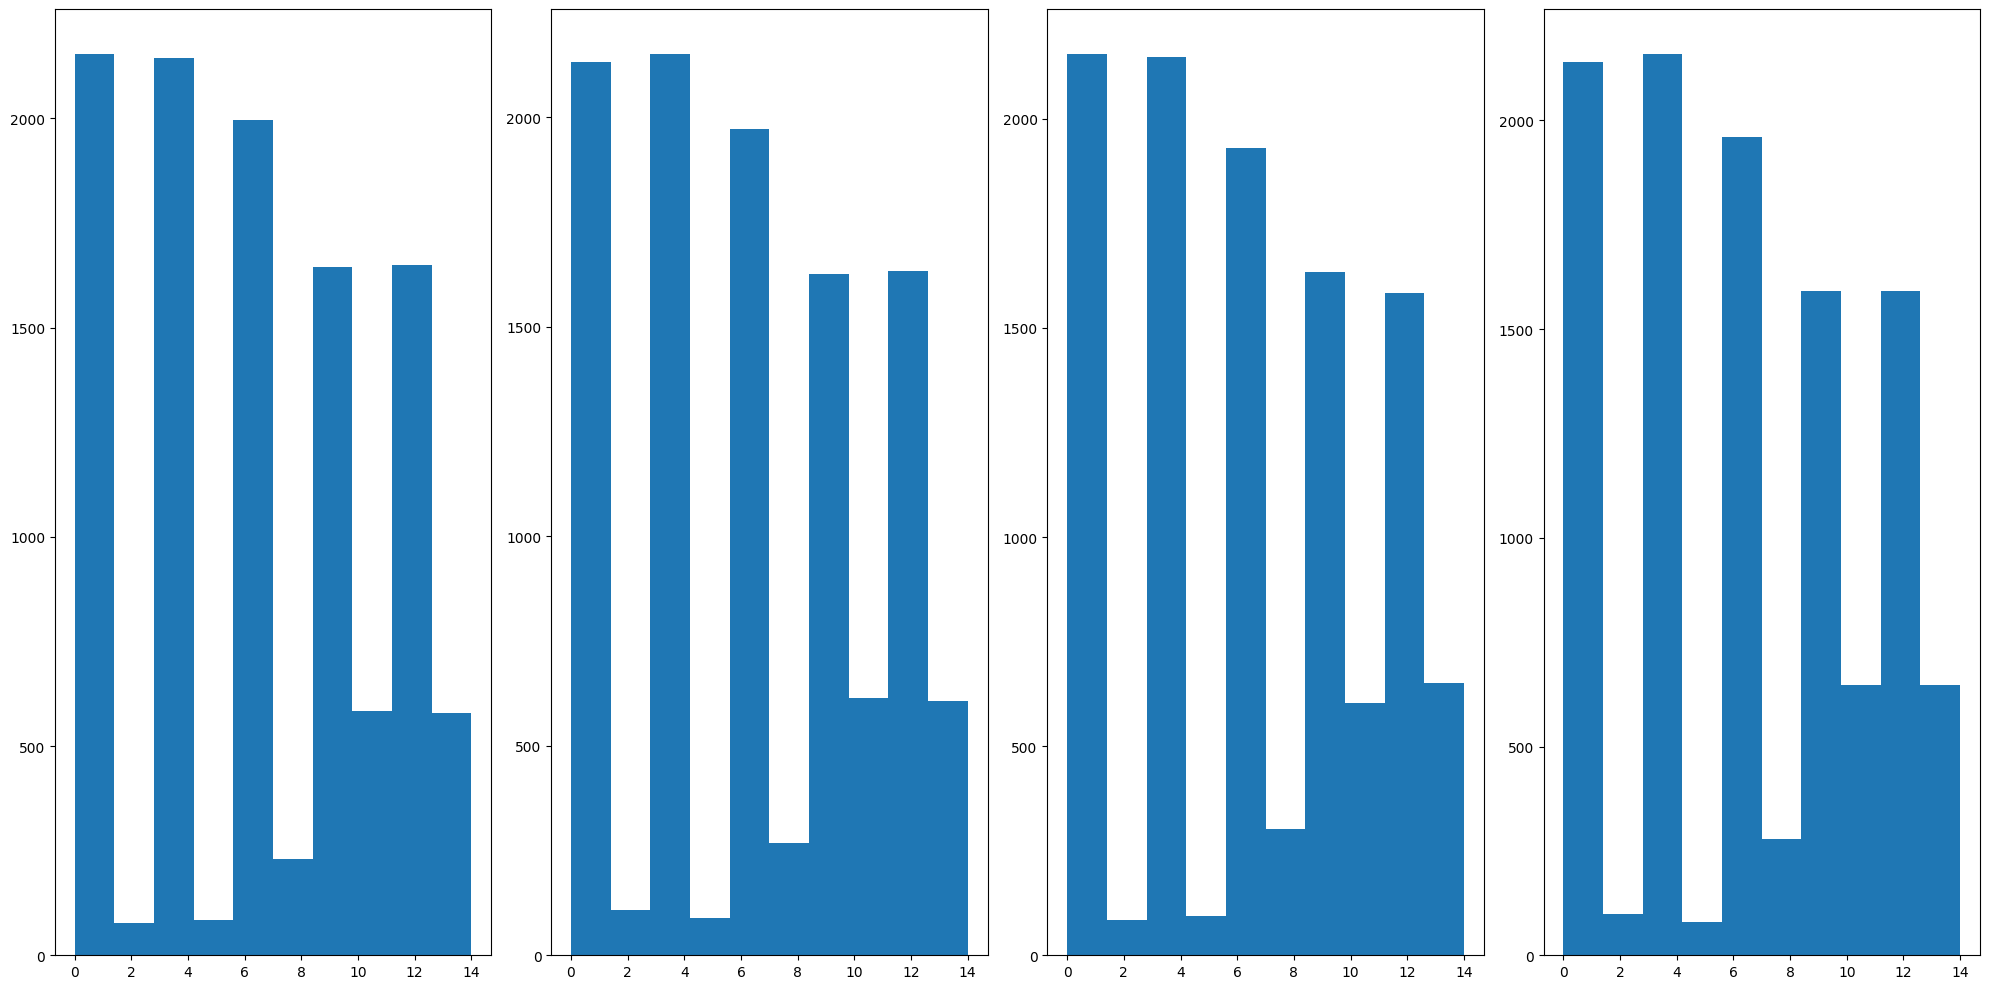

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for fold in range(0, 4):
    this = t123.filter(pl.col('fold') == fold).to_pandas()
    
    axs[fold].hist(this['labels'].values)
    
plt.tight_layout()
plt.show()

In [26]:
t123.write_csv('merged_train.csv')

In [27]:
# 1261271580 have 4 series (2 sagt1)

# Create Coordinates df

In [28]:
coords_dict = {
    'study_id': [],
    'series_id': [],
    'study_id_level': [],
    'series_description': [],
    'condition': [],
    'level': [],
    'patient_coords': []
}

for name, data in t123.filter(pl.col('series_description') != 'Axial T2').group_by(['study_id'], maintain_order=True):

    for name2, data2 in data.group_by(['series_id'], maintain_order=True):
        study_id = data2['study_id'].unique().item(0)
        series_id = data2['series_id'].unique().item(0)
        series_description = data2['series_description'].unique().item(0)
        
        ins_nums = data2['instance_number'].to_numpy()
        coords = data2.select(['x', 'y']).to_numpy()
        conds = data2['condition'].to_list()
        levels = data2['level'].to_list()

        for ins_num, (x, y), cond, level in zip(ins_nums, coords, conds, levels):
            path = os.path.join(train_images_path, f'{study_id}/{series_id}/{int(ins_num)}.dcm')
            dcm = pydicom.dcmread(path)
            
            pixel_spacing = dcm.PixelSpacing
            image_position = dcm.ImagePositionPatient
            image_orientation = dcm.ImageOrientationPatient
            
            row_vector = np.array(image_orientation[:3])
            col_vector = np.array(image_orientation[3:])

            patient_coords = [
                image_position[0] + x * pixel_spacing[1] * row_vector[0] + y * pixel_spacing[0] * col_vector[0],
                image_position[1] + x * pixel_spacing[1] * row_vector[1] + y * pixel_spacing[0] * col_vector[1],
                image_position[2] + x * pixel_spacing[1] * row_vector[2] + y * pixel_spacing[0] * col_vector[2]
            ]
            coords_dict['study_id'].append(study_id)
            coords_dict['series_id'].append(series_id)
            coords_dict['study_id_level'].append(str(study_id) + '_' + level)
            coords_dict['series_description'].append(series_description)
            coords_dict['condition'].append(cond)
            coords_dict['level'].append(level)
            coords_dict['patient_coords'].append(patient_coords)

In [29]:
patient_coords_df = pl.DataFrame(coords_dict)
patient_coords_df

study_id,series_id,study_id_level,series_description,condition,level,patient_coords
i64,i64,str,str,str,str,list[f64]
100206310,2092806862,"""100206310_l1_l2""","""Sagittal T1""","""left_neural_foraminal_narrowin…","""l1_l2""","[25.180714, 70.668968, -471.739934]"
100206310,2092806862,"""100206310_l2_l3""","""Sagittal T1""","""left_neural_foraminal_narrowin…","""l2_l3""","[19.797771, 64.055176, -501.391838]"
100206310,2092806862,"""100206310_l3_l4""","""Sagittal T1""","""left_neural_foraminal_narrowin…","""l3_l4""","[23.383351, 57.245982, -530.706189]"
100206310,2092806862,"""100206310_l4_l5""","""Sagittal T1""","""left_neural_foraminal_narrowin…","""l4_l5""","[18.263075, 56.924985, -558.209434]"
100206310,2092806862,"""100206310_l5_s1""","""Sagittal T1""","""left_neural_foraminal_narrowin…","""l5_s1""","[17.791549, 63.644464, -588.97394]"
…,…,…,…,…,…,…
992674144,1576603050,"""992674144_l1_l2""","""Sagittal T2/STIR""","""spinal_canal_stenosis""","""l1_l2""","[-7.099515, 94.98095, 77.300337]"
992674144,1576603050,"""992674144_l2_l3""","""Sagittal T2/STIR""","""spinal_canal_stenosis""","""l2_l3""","[-6.155524, 86.875752, 47.971092]"
992674144,1576603050,"""992674144_l3_l4""","""Sagittal T2/STIR""","""spinal_canal_stenosis""","""l3_l4""","[-5.001193, 81.087824, 11.695446]"


In [30]:
patient_coords_df.write_parquet('patient_coords.parquet')

In [31]:
axial_img_pos_dict = {
    'study_id': [],
    'series_id': [],
    'instance_number': [],
    'ImagePositionPatient_x': [],
    'ImagePositionPatient_y': [],
    'ImagePositionPatient_z': [],
    'SliceLocation': [],
    'SpacingBetweenSlices': [],
    'PatientPosition': [],
}

for name, data in t123.filter(pl.col('series_description') == 'Axial T2').group_by(['study_id', 'series_id'], maintain_order=True):
    study_id = name[0]
    series_id = name[1]
    
    dcm_path = Path(os.path.join(train_images_path, f'{study_id}/{series_id}/')).glob('*.dcm')
    for path in dcm_path:
        dcm = pydicom.dcmread(path)
        img_pos = np.asarray(dcm.ImagePositionPatient)
        slice_loc = float(dcm.SliceLocation)
        space = float(dcm.SpacingBetweenSlices)
        ins_num = int(dcm.InstanceNumber)
        p_pos = dcm.PatientPosition
        
        axial_img_pos_dict['study_id'].append(study_id)
        axial_img_pos_dict['series_id'].append(series_id)
        axial_img_pos_dict['instance_number'].append(ins_num)
        axial_img_pos_dict['ImagePositionPatient_x'].append(img_pos[0])
        axial_img_pos_dict['ImagePositionPatient_y'].append(img_pos[1])
        axial_img_pos_dict['ImagePositionPatient_z'].append(img_pos[2])
        axial_img_pos_dict['SliceLocation'].append(slice_loc)
        axial_img_pos_dict['SpacingBetweenSlices'].append(space)
        axial_img_pos_dict['PatientPosition'].append(p_pos)

In [32]:
axial_img_pos_df = pl.DataFrame(axial_img_pos_dict).sort(['study_id', 'series_id', 'instance_number']).join(train_des, on=['study_id', 'series_id'])
axial_img_pos_df

study_id,series_id,instance_number,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceLocation,SpacingBetweenSlices,PatientPosition,series_description
i64,i64,i64,f64,f64,f64,f64,f64,str,str
4003253,2448190387,1,-95.20284,-25.970026,-375.1405,-376.11313,4.4,"""HFS""","""Axial T2"""
4003253,2448190387,2,-95.229935,-26.046228,-379.53976,-380.51312,4.4,"""HFS""","""Axial T2"""
4003253,2448190387,3,-95.25703,-26.12243,-383.939,-384.91312,4.4,"""HFS""","""Axial T2"""
4003253,2448190387,4,-95.28412,-26.19864,-388.33826,-389.3131,4.4,"""HFS""","""Axial T2"""
4003253,2448190387,5,-95.31121,-26.274843,-392.73752,-393.71313,4.4,"""HFS""","""Axial T2"""
…,…,…,…,…,…,…,…,…,…
4290709089,3390218084,19,-96.953393,-33.433417,-521.714254,-438.606804,4.8,"""HFS""","""Axial T2"""
4290709089,3390218084,20,-97.016189,-31.066516,-525.889638,-443.406804,4.8,"""HFS""","""Axial T2"""
4290709089,3390218084,21,-97.078985,-28.699618,-530.065027,-448.206805,4.8,"""HFS""","""Axial T2"""


In [33]:
axial_img_pos_df.write_parquet('axial_img_pos.parquet')

In [34]:
sagittal_img_pos_dict = {
    'study_id': [],
    'series_id': [],
    'instance_number': [],
    'ImagePositionPatient_x': [],
    'ImagePositionPatient_y': [],
    'ImagePositionPatient_z': [],
    'SliceLocation': [],
    'SpacingBetweenSlices': [],
    'PatientPosition': [],
}

for name, data in t123.filter(pl.col('series_description') != 'Axial T2').group_by(['study_id', 'series_id'], maintain_order=True):
    study_id = name[0]
    series_id = name[1]
    
    dcm_path = Path(os.path.join(train_images_path, f'{study_id}/{series_id}/')).glob('*.dcm')
    for path in dcm_path:
        dcm = pydicom.dcmread(path)
        img_pos = np.asarray(dcm.ImagePositionPatient)
        slice_loc = float(dcm.SliceLocation)
        space = float(dcm.SpacingBetweenSlices)
        ins_num = int(dcm.InstanceNumber)
        p_pos = dcm.PatientPosition
        
        sagittal_img_pos_dict['study_id'].append(study_id)
        sagittal_img_pos_dict['series_id'].append(series_id)
        sagittal_img_pos_dict['instance_number'].append(ins_num)
        sagittal_img_pos_dict['ImagePositionPatient_x'].append(img_pos[0])
        sagittal_img_pos_dict['ImagePositionPatient_y'].append(img_pos[1])
        sagittal_img_pos_dict['ImagePositionPatient_z'].append(img_pos[2])
        sagittal_img_pos_dict['SliceLocation'].append(slice_loc)
        sagittal_img_pos_dict['SpacingBetweenSlices'].append(space)
        sagittal_img_pos_dict['PatientPosition'].append(p_pos)

In [35]:
sagittal_img_pos_df = pl.DataFrame(sagittal_img_pos_dict).sort(['study_id', 'series_id', 'instance_number']).join(train_des, on=['study_id', 'series_id'])
sagittal_img_pos_df

study_id,series_id,instance_number,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceLocation,SpacingBetweenSlices,PatientPosition,series_description
i64,i64,i64,f64,f64,f64,f64,f64,str,str
4003253,702807833,1,-31.881287,-76.68697,-283.0574,-33.939922,4.8,"""HFS""","""Sagittal T2/STIR"""
4003253,702807833,2,-27.081406,-76.681274,-283.02402,-29.139921,4.8,"""HFS""","""Sagittal T2/STIR"""
4003253,702807833,3,-22.281525,-76.67558,-282.99063,-24.33992,4.8,"""HFS""","""Sagittal T2/STIR"""
4003253,702807833,4,-17.481644,-76.66989,-282.95724,-19.53992,4.8,"""HFS""","""Sagittal T2/STIR"""
4003253,702807833,5,-12.681765,-76.66419,-282.92386,-14.739921,4.8,"""HFS""","""Sagittal T2/STIR"""
…,…,…,…,…,…,…,…,…,…
4290709089,4237840455,11,22.405454,-87.967921,-249.765748,26.75984,4.6,"""HFS""","""Sagittal T1"""
4290709089,4237840455,12,27.004516,-87.942286,-249.855057,31.35984,4.6,"""HFS""","""Sagittal T1"""
4290709089,4237840455,13,31.603578,-87.916652,-249.944365,35.959841,4.6,"""HFS""","""Sagittal T1"""


In [36]:
sagittal_img_pos_df.write_parquet('sagittal_img_pos.parquet')